# DACON - 영화 관객수 예측 경진대회
[DACON - 영화 관객수 예측 경진대회](https://dacon.io/competitions/open/235536/data)
## EDA and Preprocessing

### 사용 라이브러리



In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import re
from glob import glob
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgbm
from lightgbm import LGBMRegressor

xgboost와 lgbm을 사용했지만, 다른 모델을 사용해도 상관 없습니다

### Data Load

In [2]:
paths = glob("data/movie/*.csv")
paths

['data/movie/submission.csv',
 'data/movie/movies_test.csv',
 'data/movie/movies_train.csv']

In [3]:
train, test = pd.read_csv(paths[2]), pd.read_csv(paths[1])

train.shape, test.shape

((600, 12), (243, 11))

In [4]:
# train과 test의 데이터를 출력해봅니다
display(train.head(3))
display(test.head(3))

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7


- title : 영화의 제목
- distributor : 배급사
- genre : 장르
- release_time : 개봉일
- time : 상영시간(분)
- screening_rat : 상영등급
- director : 감독이름
- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
- dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
- num_staff : 스텝수
- num_actor : 주연배우수
- box_off_num : 관객수

### EDA and Preprocessing
#### 기본 정보

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [6]:
# 통계값을 소수점 2자리까지만 확인 해봅니다 (train)
round(train.describe(), 2)

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.00,270.00,600.00,600.00,600.00,600.00
mean,100.86,1050442.89,0.88,151.12,3.71,708181.75
std,18.10,1791408.30,1.18,165.65,2.45,1828005.85
min,45.00,1.00,0.00,0.00,0.00,1.00
25%,89.00,20380.00,0.00,17.00,2.00,1297.25
50%,100.00,478423.62,0.00,82.50,3.00,12591.00
75%,114.00,1286568.62,2.00,264.00,4.00,479886.75
max,180.00,17615314.00,5.00,869.00,25.00,14262766.00


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


In [8]:
# 통계값을 소수점 2자리까지만 확인 해봅니다 (test)
round(test.describe(), 2)

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,243.00,107.00,243.00,243.00,243.00
mean,109.80,891669.52,0.85,159.32,3.48
std,124.02,1217341.45,1.20,162.98,2.11
min,40.00,34.00,0.00,0.00,0.00
25%,91.00,62502.00,0.00,18.00,2.00
50%,104.00,493120.00,0.00,105.00,3.00
75%,114.50,1080849.58,1.00,282.00,4.00
max,2015.00,6173099.50,6.00,776.00,16.00


#### 결측치 확인

In [9]:
# train
train.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [10]:
# test
test.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

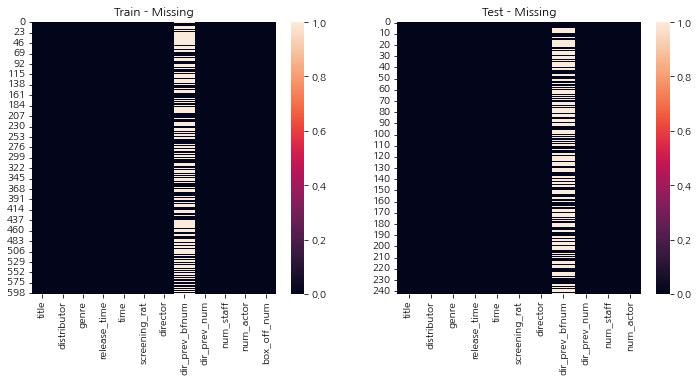

In [11]:
# 결측치를 시각화해봅니다
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.heatmap(data=train.isnull(), ax=axes[0]).set_title("Train - Missing")
sns.heatmap(data=test.isnull(), ax=axes[1]).set_title("Test - Missing");

`dir_prev_bfnum`은 해당 감독이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수부분에 결측치가 존재함  
관객수가 알려지지 않은 부분이 결측치로 존재하는거라, 정보가 없다라는 정보 그 자체로 사용해도 괜찮을꺼 같음

#### distributor: 배급사

In [12]:
# \(|주|\) 는 데이터에서 제거해줍니다
train["distributor"] = train["distributor"].str.replace("\(|주|\)", "", regex=True)
train["distributor"]

0       롯데엔터테인먼트
1            쇼박스
2            쇼박스
3            NEW
4      쇼박스미디어플렉스
         ...    
595          NEW
596          쇼박스
597       마운틴픽쳐스
598    CJ 엔터테인먼트
599    CJ 엔터테인먼트
Name: distributor, Length: 600, dtype: object

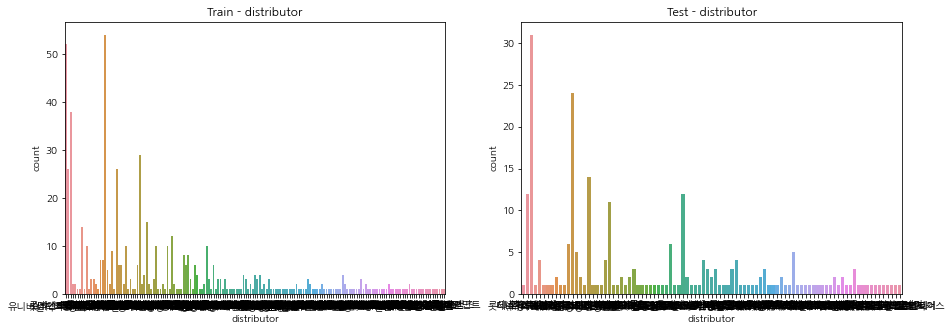

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.countplot(x=train.distributor, ax=axes[0]).set_title("Train - distributor")
sns.countplot(x=test.distributor, ax=axes[1]).set_title("Test - distributor");

In [14]:
# 정규 표현식으로 문자와 숫자만 
train["distributor"] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

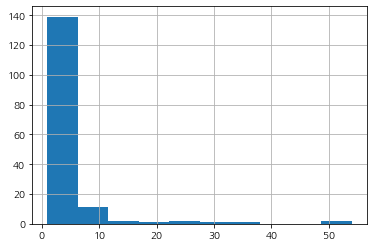

In [15]:
_ = train["distributor"].value_counts().hist()

In [16]:
# 배급사의 개수를 이용해 소형, 중대형으로 분리하기 위한 함수를 작성합니다
# 15개 이하면 소형, 이외면 중대형으로 분류 합니다
def distributor_band(x, data): 
    
    df = pd.DataFrame(data["distributor"].value_counts())
    df_i = df[df["distributor"]>15].index
    
    if x in df_i:
        return "중대형"
    else:
        return "소형"

In [17]:
train["distributor"].apply(lambda x: distributor_band(x, train)).value_counts()

소형     357
중대형    243
Name: distributor, dtype: int64

In [18]:
test["distributor"].apply(lambda x: distributor_band(x, test)).value_counts()

소형     188
중대형     55
Name: distributor, dtype: int64

In [20]:
# 위 함수를 train과 test에 모두 적용합니다
train["distributor"] = train["distributor"].apply(lambda x: distributor_band(x, train))
test["distributor"] = test["distributor"].apply(lambda x: distributor_band(x, test))

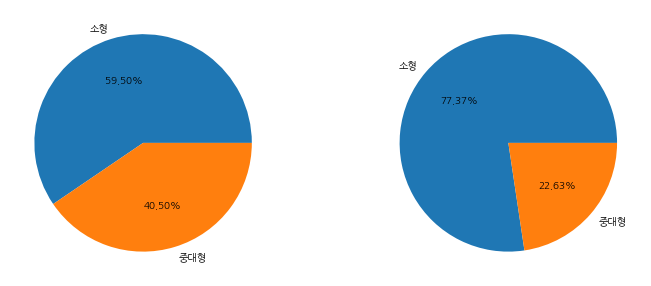

In [21]:
# pie 차트는 다음과 같이 그릴 수 있습니다
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].pie(train["distributor"].value_counts().values, labels=train["distributor"].value_counts().index, autopct="%.2f%%")
ax[1].pie(test["distributor"].value_counts().values, labels=test["distributor"].value_counts().index, autopct="%.2f%%")
plt.show()

#### genre: 장르


In [22]:
train.groupby("genre")["box_off_num"].mean().sort_values()

genre
뮤지컬       6.627000e+03
다큐멘터리     6.717226e+04
서스펜스      8.261100e+04
애니메이션     1.819267e+05
멜로/로맨스    4.259680e+05
미스터리      5.275482e+05
공포        5.908325e+05
드라마       6.256898e+05
코미디       1.193914e+06
SF        1.788346e+06
액션        2.203974e+06
느와르       2.263695e+06
Name: box_off_num, dtype: float64

In [23]:
# 위에서 구한 장르로
# rank 딕셔너리를 하드코딩합니다
# 인코딩하는 과정입니다
rank = {'느와르' : 1, '액션' : 2, 'SF' : 3, '코미디' : 4, '드라마' : 5
        , '공포' : 6, '미스터리' : 7, '멜로/로맨스' : 8, '애니메이션' : 9, '서스펜스' : 10, '다큐멘터리': 11, '뮤지컬' : 12}

In [24]:
train["rank_genre"] = train["genre"].apply(lambda x: rank[x])
test["rank_genre"] = test["genre"].apply(lambda x: rank[x])

In [25]:
# 인코딩 전의 장르 컬럼은 버려줍니다
train = train.drop("genre", axis=1)
test = test.drop("genre", axis=1)

### release_time: 개봉일

In [26]:
# 개봉일의 데이터타입은 datetime으로 변경합니다
train["release_time"] = pd.to_datetime(train["release_time"])
train["release_time"]

0     2012-11-22
1     2015-11-19
2     2013-06-05
3     2012-07-12
4     2010-11-04
         ...    
595   2014-08-13
596   2013-03-14
597   2010-09-30
598   2015-05-14
599   2013-01-30
Name: release_time, Length: 600, dtype: datetime64[ns]

In [27]:
test["release_time"] = pd.to_datetime(test["release_time"])
test["release_time"]

0     2010-01-07
1     2010-01-14
2     2010-01-28
3     2010-02-04
4     2010-02-18
         ...    
238   2015-11-19
239   2015-10-29
240   2015-10-28
241   2015-10-22
242   2015-10-22
Name: release_time, Length: 243, dtype: datetime64[ns]

In [28]:
# 연 월 일 요일 파생 변수를 train과 test에 생성합니다
train["year"] = train["release_time"].dt.year
train["month"] = train["release_time"].dt.month
train["day"] = train["release_time"].dt.day
train["dayofweek"] = train["release_time"].dt.dayofweek

In [29]:
test["year"] = test["release_time"].dt.year
test["month"] = test["release_time"].dt.month
test["day"] = test["release_time"].dt.day
test["dayofweek"] = test["release_time"].dt.dayofweek

In [30]:
# 기존 데이터는 삭제합니다
train = train.drop("release_time", axis=1)
test = test.drop("release_time", axis=1)

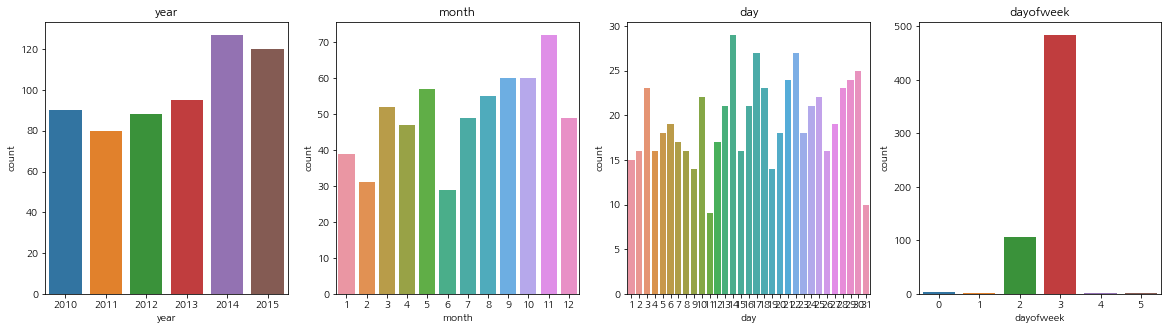

In [31]:
# 요일별로 시각화 해봅니다 - train
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

sns.countplot(x=train.year, ax=axes[0]).set_title("year")
sns.countplot(x=train.month, ax=axes[1]).set_title("month")
sns.countplot(x=train.day, ax=axes[2]).set_title("day")
sns.countplot(x=train.dayofweek, ax=axes[3]).set_title("dayofweek");

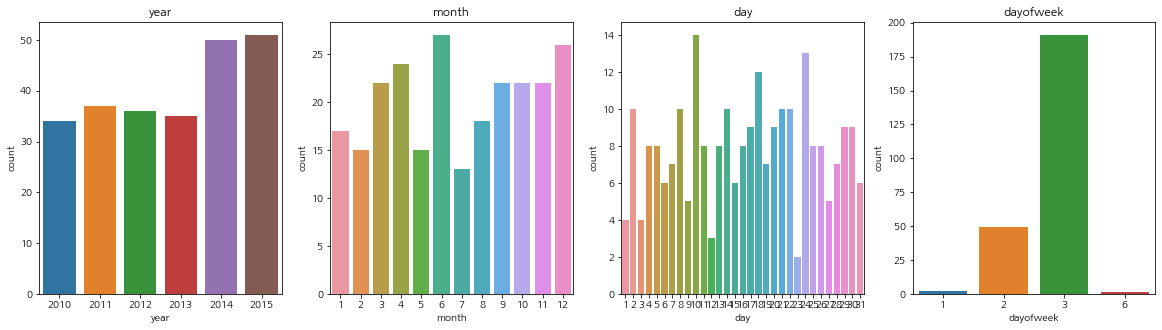

In [32]:
# 요일별로 시각화 해봅니다 - test
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

sns.countplot(x=test.year, ax=axes[0]).set_title("year")
sns.countplot(x=test.month, ax=axes[1]).set_title("month")
sns.countplot(x=test.day, ax=axes[2]).set_title("day")
sns.countplot(x=test.dayofweek, ax=axes[3]).set_title("dayofweek");

수요일, 목요일에 개봉한 영화들이 많고 목요일에 개봉한 영화가 유독 많음

## Train

In [34]:
# 제목과 감독 데이터는 버려줍니다
train.drop("director", axis=1, inplace=True)
test.drop("director", axis=1, inplace=True)

train.drop("title", axis=1, inplace=True)
test.drop("title", axis=1, inplace=True)

In [35]:
train["dir_prev_bfnum"].fillna(0, inplace=True)
test["dir_prev_bfnum"].fillna(0, inplace=True)

In [36]:
# 범주형 데이터들을 인코딩해줍니다 - train
screening = pd.get_dummies(train["screening_rat"], prefix='screening_rat')
distributor = pd.get_dummies(train["distributor"], prefix='distributor')
df_train = pd.concat([train, distributor, screening], axis=1).copy()
df_train

,distributor,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,rank_genre,year,month,day,dayofweek,distributor_소형,distributor_중대형,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,중대형,96,청소년 관람불가,0.00,0,91,2,23398,2,2012,11,22,3,0,1,0,0,0,1
1,중대형,130,청소년 관람불가,1161602.50,2,387,3,7072501,1,2015,11,19,3,0,1,0,0,0,1
2,중대형,123,15세 관람가,220775.25,4,343,4,6959083,2,2013,6,5,2,0,1,0,1,0,0
3,중대형,101,전체 관람가,23894.00,2,20,6,217866,4,2012,7,12,3,0,1,0,0,1,0
4,소형,108,15세 관람가,1.00,1,251,2,483387,4,2010,11,4,3,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,중대형,111,청소년 관람불가,3833.00,1,510,7,1475091,5,2014,8,13,2,0,1,0,0,0,1
596,중대형,127,15세 관람가,496061.00,1,286,6,1716438,5,2013,3,14,3,0,1,0,1,0,0
597,중대형,99,청소년 관람불가,0.00,0,123,4,2475,6,2010,9,30,3,0,1,0,0,0,1
598,중대형,102,15세 관람가,0.00,0,431,4,2192525,1,2015,5,14,3,0,1,0,1,0,0


In [37]:
# 범주형 데이터들을 인코딩해줍니다 - test
screening = pd.get_dummies(test["screening_rat"], prefix='screening_rat')
distributor = pd.get_dummies(test["distributor"], prefix='distributor')
df_test = pd.concat([test, distributor, screening], axis=1).copy()
df_test

,distributor,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,rank_genre,year,month,day,dayofweek,distributor_소형,distributor_중대형,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,소형,125,청소년 관람불가,3.005290e+05,2,304,3,1,2010,1,7,3,1,0,0,0,0,1
1,소형,113,12세 관람가,3.427002e+05,4,275,3,8,2010,1,14,3,1,0,1,0,0,0
2,중대형,115,12세 관람가,4.206611e+06,3,419,7,5,2010,1,28,3,0,1,1,0,0,0
3,소형,116,15세 관람가,6.913420e+05,2,408,2,2,2010,2,4,3,1,0,0,1,0,0
4,중대형,110,15세 관람가,3.173800e+04,1,380,1,6,2010,2,18,3,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,소형,78,15세 관람가,2.590000e+03,1,4,4,5,2015,11,19,3,1,0,0,1,0,0
239,소형,86,12세 관람가,0.000000e+00,0,18,2,11,2015,10,29,3,1,0,1,0,0,0
240,소형,107,청소년 관람불가,0.000000e+00,0,224,4,1,2015,10,28,2,1,0,0,0,0,1
241,소형,102,청소년 관람불가,5.069900e+04,1,68,7,5,2015,10,22,3,1,0,0,0,0,1


In [38]:
df_train.columns

Index(['distributor', 'time', 'screening_rat', 'dir_prev_bfnum',
       'dir_prev_num', 'num_staff', 'num_actor', 'box_off_num', 'rank_genre',
       'year', 'month', 'day', 'dayofweek', 'distributor_소형',
       'distributor_중대형', 'screening_rat_12세 관람가', 'screening_rat_15세 관람가',
       'screening_rat_전체 관람가', 'screening_rat_청소년 관람불가'],
      dtype='object')

In [39]:
df_train.drop("screening_rat", axis=1, inplace=True)
df_test.drop("screening_rat", axis=1, inplace=True)

df_train.drop("distributor", axis=1, inplace=True)
df_test.drop("distributor", axis=1, inplace=True)

In [40]:
# 피처와 라벨을 구합니다
features = ['time',
 'dir_prev_bfnum',
 'dir_prev_num',
 'num_staff',
 'num_actor',
 'rank_genre',
 'year',
 'month',
 'day',
 'dayofweek',
 'distributor_소형',
 'distributor_중대형',
 'screening_rat_12세 관람가',
 'screening_rat_15세 관람가',
 'screening_rat_전체 관람가',
 'screening_rat_청소년 관람불가']
features

['time',
 'dir_prev_bfnum',
 'dir_prev_num',
 'num_staff',
 'num_actor',
 'rank_genre',
 'year',
 'month',
 'day',
 'dayofweek',
 'distributor_소형',
 'distributor_중대형',
 'screening_rat_12세 관람가',
 'screening_rat_15세 관람가',
 'screening_rat_전체 관람가',
 'screening_rat_청소년 관람불가']

In [41]:
# 피처와 라벨을 구합니다
label = "box_off_num"
label

'box_off_num'

### Log Scale

In [42]:
# 등장 배우의 수에 로그 스케일을 적용합니다
df_train["num_actor"] = np.log1p(df_train["num_actor"])
df_test["num_actor"] = np.log1p(df_test["num_actor"])

In [43]:
X_train, X_val, y_train, y_val = train_test_split(df_train[features], df_train[label], test_size=0.15)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_val: {X_val.shape}\ny_val: {y_val.shape}")

X_train: (510, 16)
y_train: (510,)
X_val: (90, 16)
y_val: (90,)


In [45]:
df_test.shape

(243, 16)

### Random Forest

In [62]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, random_state=42)
model

RandomForestRegressor(n_jobs=-1, random_state=42)

In [64]:
y_predict = model.fit(X_train, y_train).predict(X_val)
y_predict[:5]

array([4.95494692e+06, 1.82573800e+04, 1.49019103e+06, 2.86131965e+06,
       4.06164000e+03])

In [65]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_val, y_predict) ** 0.5
print(f"rmse: {rmse}")

rmse: 1535170.4638599977


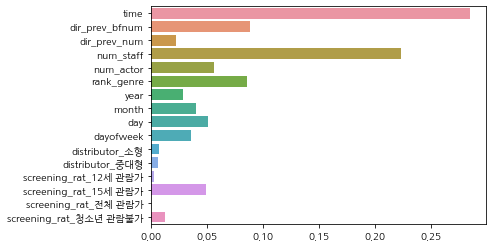

In [67]:
sns.barplot(x=model.feature_importances_, y=model.feature_names_in_);

### XGBoost

In [53]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [68]:
xgb_predict = xgb_model.predict(X_val)
xgb_predict[:5]

array([ 9.1877930e+06, -7.9682456e+03,  1.0656182e+06,  2.6718885e+06,
        3.8449189e+03], dtype=float32)

In [70]:
rmse = np.sqrt((np.square(y_val - xgb_predict)).mean())
print(f"rmse: {rmse}")

rmse: 1786423.2557963203


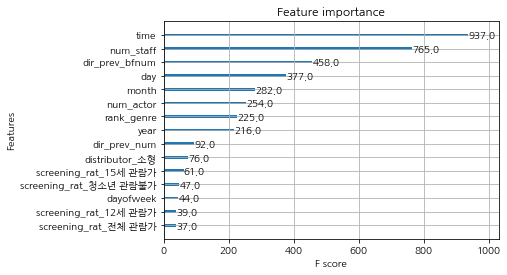

In [55]:
xgb.plot_importance(xgb_model);

### LightGBM

In [74]:
lgbm_model = LGBMRegressor(random_state=42)
lgbm_model

LGBMRegressor(random_state=42)

In [76]:
lgbm_predict = lgbm_model.fit(X_train, y_train).predict(X_val)
lgbm_predict[:5]

array([5183802.71967785,   96174.5899679 , 1115182.86785708,
       2282460.34251488,  -15931.93768882])

In [77]:
rmse = np.sqrt((np.square(y_val - lgbm_predict)).mean())
print(f"rmse: {rmse}")

rmse: 1642238.2701070984


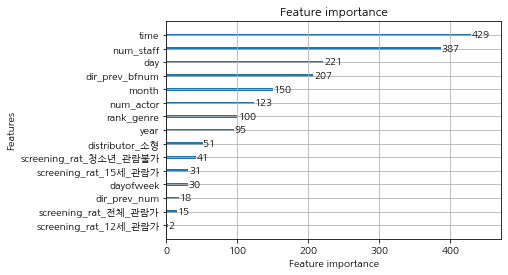

In [78]:
lgbm.plot_importance(lgbm_model);